In [30]:
import math
import os
# os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
import torch
from torch import nn
from torch.distributions.categorical import Categorical
from d2l import torch as d2l
import pandas as pd
import pickle
import numpy as np 
import time 
import matplotlib.pyplot as plt 

#### Check GPU availability

In [31]:
print("GPU availability: {}".format(torch.cuda.is_available()))
print("Number of GPU available: {}".format(torch.cuda.device_count()))

GPU availability: False
Number of GPU available: 0


#### Clean GPU usage

In [32]:
# to train a new model, restart kernel after freeing gpu memory
# and load all pretraining data

from GPUtil import showUtilization as gpu_usage
from numba import cuda

def free_gpu_cache():
    print("Initial GPU Usage")
    gpu_usage()                             

    torch.cuda.empty_cache()

    cuda.select_device(0)
    cuda.close()
    cuda.select_device(0)

    print("GPU Usage after emptying the cache")
    gpu_usage()

In [33]:
# check gpu_usage
#gpu_usage()

#### Heatmap

In [34]:
def show_heatmaps(matrices, xlabel, ylabel, titles=None, figsize=(2.5, 2.5), cmap="Reds"):
	d2l.use_svg_display()
	num_rows, num_cols = matrices.shape[0], matrices.shape[1]
	fig, axes = d2l.plt.subplots(num_rows, num_cols, figsize=figsize, sharex=True, sharey=True, squeeze=False) # shape0, shape1 -- number of subplots

	for i, (row_axes, row_matrices) in enumerate(zip(axes, matrices)): # row_axes seperate out first dimension -- (1, 1, 10, 10) to (1, 10, 10)
		for j, (ax, matrix) in enumerate(zip(row_axes, row_matrices)): # ax seperate out second dimension -- (1, 10, 10) to (10, 10)
			pcm = ax.imshow(matrix.detach().numpy(), cmap=cmap)
			if i == num_rows - 1:
				ax.set_xlabel(xlabel) # we may have (row, col) subplots -- we set xlabel at once at the bottom
			if j == 0:
				ax.set_ylabel(ylabel)
			if titles:
				ax.set_title(titles[j]) # a list a subtitles
	fig.colorbar(pcm, ax=axes, shrink=0.6)

#### Masked sequence

In [35]:
# X: (5, 10)
# value: [1, 5, 3, 6, 2] -- matching the rows 

def sequence_mask(X, valid_len, value=0):
	"""Mask irrelevant entries in sequences."""

	maxlen = X.size(1)
	mask = torch.arange((maxlen), dtype=torch.float32, device=X.device)[None, :] < valid_len[:, None]
	#print(mask)

	X[~mask] = value # set the masked elements to value 
	return X

#### Masked softmax operation

In [36]:
# X: (2, 3, 4) -- attention weights
# valid lens: specify how many elements to mask in each minibatch 
# valid lens (high dim): specify how to mask each minibatch 
def masked_softmax(X, valid_lens):
	"""Perform softmax operation by masking elements on the last axis"""

	if valid_lens == None:
		return nn.functional.softmax(X, dim=-1)
	else:
		shape = X.shape
		if valid_lens.dim() == 1:
			# 
			valid_lens = torch.repeat_interleave(valid_lens, shape[1])
		else:
			valid_lens = valid_lens.reshape(-1)
		X = sequence_mask(X.reshape(-1, shape[-1]), valid_lens, value=-1e6)

		return nn.functional.softmax(X.reshape(shape), dim=-1)

#### Positional encoding

In [37]:
class PositionalEncoding(nn.Module):
	"""Position encoding X+P with dropout"""

	def __init__(self, num_hiddens, dropout, max_len=1000):
		super(PositionalEncoding, self).__init__()
		self.dropout = nn.Dropout(dropout)

		# create a single batch_size 1, long enough P, longer than sequence length
		self.P = torch.zeros((1, max_len, num_hiddens))
		X = torch.arange(max_len, dtype=torch.float32).reshape(-1, 1) / torch.pow(10000, torch.arange(0, num_hiddens, 2, dtype=torch.float32)/num_hiddens)
		self.P[:, :, 0::2] = torch.sin(X)
		self.P[:, :, 1::2] = torch.cos(X)

	def forward(self, X):
		X = X + self.P[:, :X.shape[1], :].to(X.device)
		return self.dropout(X)

#### Scaled dot-product attention

In [38]:
class DotProductAttention(nn.Module):
	""""Scaled dot product attention with dropout"""

	def __init__(self, dropout, **kwargs):
		super(DotProductAttention, self).__init__(**kwargs)
		self.dropout = nn.Dropout(dropout)

		# query: (batch_size, no. of queries, 'd')
		# key: (batch_size, no. of key-value pairs, 'd')
		# value: (batch_size, no. of key-value pairs, d_value)
		# valid_lens: (batch_size, ) or (batch_size, no. of queries)
	
	def forward(self, queries, keys, values, valid_lens=None):
		d = queries.shape[-1]

		scores = torch.bmm(queries, keys.transpose(1, 2)) / math.sqrt(d)
		self.attention_weights = masked_softmax(scores, valid_lens)
		return torch.bmm(self.dropout(self.attention_weights), values)

#### Multi-head attention

In [39]:
def transpose_qkv(X, num_heads):
	"""Transposition for parallel computation of multiple attention heads"""

	X = X.reshape(X.shape[0], X.shape[1], num_heads, -1)
	X = X.permute(0, 2, 1, 3)

	return X.reshape(-1, X.shape[2], X.shape[3])

def transpose_output(X, num_heads):
	"""Reverse the operation of transpose_qkv"""

	X = X.reshape(-1, num_heads, X.shape[1], X.shape[2])
	X = X.permute(0, 2, 1, 3)

	return X.reshape(X.shape[0], X.shape[1], -1)

In [40]:
# valid_lens: (batch_size, ) or (batch_size, no. of queries)
# Note: the mask (valid_len) used here, I copy it num_heads times

class MultiHeadAttention(nn.Module):
	"""Multi-head attention"""

	def __init__(self, key_size, query_size, value_size, num_hiddens, num_heads, dropout, use_bias=False, **kwargs):
		super(MultiHeadAttention, self).__init__(**kwargs)
		self.num_heads = num_heads
		self.attention = DotProductAttention(dropout)
		self.W_q = nn.Linear(query_size, num_hiddens, bias=use_bias) # (in_feature, out_feature)
		self.W_k = nn.Linear(key_size, num_hiddens, bias=use_bias)
		self.W_v = nn.Linear(value_size, num_hiddens, bias=use_bias)
		self.W_o = nn.Linear(num_hiddens, num_hiddens, bias=use_bias)
	
	def forward(self, queries, keys, values, valid_lens):
		
		# queries, keys, values:
		# (batch_size, no. of queries / keys/ values, num_hiddens) ---------------------note here we choose queries_size, value_size, key_size to be num_hiddens
		# valid_lens: (batch_size, ) or (batch_size, no. of queries)

		queries = transpose_qkv(self.W_q(queries), self.num_heads)
		keys = transpose_qkv(self.W_k(keys), self.num_heads)
		values = transpose_qkv(self.W_v(values), self.num_heads)

		if valid_lens is not None:
			valid_lens = torch.repeat_interleave(valid_lens, repeats=self.num_heads, dim=0)
		
		output = self.attention(queries, keys, values, valid_lens)

		output_concat = transpose_output(output, self.num_heads)

		return self.W_o(output_concat)

#### Positionwise Feed-Forward Networks

In [41]:
class PositionWiseFFN(nn.Module):
	"""Positionwise feed-forward network"""

	def __init__(self, ffn_num_input, ffn_num_hiddens, ffn_num_outputs, **kwargs):
		super(PositionWiseFFN, self).__init__(**kwargs)
		self.dense1 = nn.Linear(ffn_num_input, ffn_num_hiddens)
		self.relu = nn.ReLU()
		self.dense2 = nn.Linear(ffn_num_hiddens, ffn_num_outputs)

	def forward(self, X):
		return self.dense2(self.relu(self.dense1(X)))

#### Residual connection and layer normalization

In [42]:
# input: (batch_size, seq_length, features_dim)
# normalized shape is input.size()[1: ]
# the normalizing direction is features_dim -- nomalizing along second dimension

# X is input 
# Y is Multiattention(X)

class AddNorm(nn.Module):
	"""Residual connection followed by layer normalization with dropout implementation"""

	def __init__(self, normalized_shape, dropout, **kwargs):
		super(AddNorm, self).__init__(**kwargs)
		self.dropout = nn.Dropout(dropout)
		self.ln = nn.LayerNorm(normalized_shape)

	def forward(self, X, Y): 
		return self.ln(self.dropout(Y) + X)

#### Encoder

In [43]:
class EncoderBlock(nn.Module):
	"""Transformer encoder block."""

	def __init__(self, key_size, query_size, value_size, num_hiddens, norm_shape, ffn_num_input, ffn_num_hiddens, num_heads, dropout, use_bias=False, **kwargs):
		super(EncoderBlock, self).__init__(**kwargs)
		self.attention = MultiHeadAttention(key_size=key_size, query_size=query_size, value_size=value_size, num_hiddens=num_hiddens, num_heads=num_heads, dropout=dropout, use_bias=use_bias)
		self.addnorm1 = AddNorm(norm_shape, dropout)
		self.ffn = PositionWiseFFN(ffn_num_input, ffn_num_hiddens, num_hiddens)
		self.addnorm2 = AddNorm(norm_shape, dropout)

	def forward(self, X, valid_lens):
		Y = self.addnorm1(X, self.attention(X, X, X, valid_lens))
		return self.addnorm2(Y, self.ffn(Y))

#### Transformer encoder

In [44]:
# we can now stack the blocks of encoders
# we also need to rescale to learnable input embeddings by sqrt(embedding dim) to [-1, 1]. This is because each value of positional embeddding is [-1, 1]
# num_layers: number of blocks of encoder
# vocab_size: size of vocabulary dictionary

class TransformerEncoder(d2l.Encoder):
	"""Transformer encoder."""

	def __init__(self, vocab_size, key_size, query_size, value_size, num_hiddens, norm_shape, ffn_num_input, ffn_num_hiddens, num_heads, num_layers, dropout, use_bias=False, **kwargs):
		super(TransformerEncoder, self).__init__(**kwargs)
		self.num_hiddens = num_hiddens
		self.embedding = nn.Embedding(vocab_size, num_hiddens) # here we randomly initialize a input embedding matrix 
		self.pos_encoding = PositionalEncoding(num_hiddens, dropout)
		self.blks = nn.Sequential()
		for i in range(num_layers):
			self.blks.add_module("Block"+str(i), EncoderBlock(key_size, query_size, value_size, num_hiddens, norm_shape, ffn_num_input, ffn_num_hiddens, num_heads, dropout, use_bias=use_bias))
	
	def forward(self, X, valid_lens, *args):
		X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
		self.attention_weights = [None] * len(self.blks) # create a attention weight list to hold attention weights at each block
		for i, blk in enumerate(self.blks):
			X = blk(X, valid_lens)
			self.attention_weights[i] = blk.attention.attention.attention_weights # the actual attention weights is stored in the ScaledDotAttention
		
		return X

#### Decoder

In [45]:
# self.i stores all previous representations

class DecoderBlock(nn.Module):
	"""The ith decoder block"""
	def __init__(self, key_size, query_size, value_size, num_hiddens, norm_shape, ffn_num_input, ffn_num_hiddens, num_heads, dropout, i, **kwargs):
		super(DecoderBlock, self).__init__(**kwargs)
		self.i = i
		self.attention1 = MultiHeadAttention(key_size=key_size, query_size=query_size, value_size=value_size, num_hiddens=num_hiddens, num_heads=num_heads, dropout=dropout)
		self.addnorm1 = AddNorm(norm_shape, dropout)
		self.attention2 = MultiHeadAttention(key_size=key_size, query_size=query_size, value_size=value_size, num_hiddens=num_hiddens, num_heads=num_heads, dropout=dropout)
		self.addnorm2 = AddNorm(norm_shape, dropout)
		self.ffn = PositionWiseFFN(ffn_num_input, ffn_num_hiddens, num_hiddens)
		self.addnorm3 = AddNorm(norm_shape, dropout)

	def forward(self, X, state):
		# state: (encoder_output, encoder_valid_len, some info)
		enc_outputs, enc_valid_lens = state[0], state[1]
		
		batch_size, num_steps, _ = X.shape # (batch_size, previous_timesteps, hidden_dimension)
		dec_valid_lens = torch.arange(1, num_steps + 1, device=X.device).repeat(batch_size, 1) # repeat to size (2, 1), this specifies how we mask each row in each minibatch
		
		# main model
		# q, k, v as defined
		X2 = self.attention1(X, X, X, dec_valid_lens) # training: all X, but we mask all after, prediction: queries=current timestep repr, keys_values, all previous 
		Y = self.addnorm1(X, X2)
		Y2 = self.attention2(Y, enc_outputs, enc_outputs, enc_valid_lens) # in the case encoder is masked 
		Z = self.addnorm2(Y, Y2)

		return self.addnorm3(Z, self.ffn(Z)), state # state here is passed as it was 

	# some additional notes: 
	# decoder consists of 2 functionality: training and prediction 

	# during training: we use the whole sequence but mask attention weights
	# The attention weights matrix has dimension (q, k) -- the second query will only get acess to the first 2 key
	# state[2] is [None]

	# during prediction: we only have current embedding -- 1 query 
	# the key-values combine current and all previous key-valuee to search for -- decoder self attention 

#### Transformer Decoder

In [46]:
class TransformerDecoder(d2l.AttentionDecoder):

	def __init__(self, vocab_size,  key_size, query_size, value_size, num_hiddens, norm_shape, ffn_num_input, ffn_num_hiddens, num_heads, num_layers, dropout, **kwargs):
		super(TransformerDecoder, self).__init__(**kwargs)
		self.num_hiddens = num_hiddens
		self.num_layers = num_layers
		self.embedding = nn.Embedding(vocab_size, num_hiddens)
		self.pos_encoding = PositionalEncoding(num_hiddens, dropout)
		self.blks = nn.Sequential()
		for i in range(num_layers):
			self.blks.add_module("block"+str(i), DecoderBlock(key_size, query_size, value_size, num_hiddens, norm_shape, ffn_num_input, ffn_num_hiddens, num_heads, dropout, i))
		self.dense = nn.Linear(num_hiddens, vocab_size)
		# prediction: we have (1, num_hiddens) --> (1, num_vocab_size)

	def init_state(self, enc_outputs, enc_valid_lens, *args):
		self.seqX = None
		return [enc_outputs, enc_valid_lens]

	def forward(self, X, state):

		if not self.training:
			if self.seqX is None:
				self.seqX = X
			else:
				self.seqX = torch.cat((self.seqX, X), dim=1)
			X = self.seqX

		X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
		self._attention_weights = [[None] * len(self.blks) for _ in range(2)] # here we record attention from 2 attention module (2, i)
		
		for i, blk in enumerate(self.blks):

			X, state = blk(X, state)
			# Decoder self-attention weights
			self._attention_weights[0][i] = blk.attention1.attention.attention_weights
			# Encoder-decoder attention weights
			self._attention_weights[1][i] = blk.attention2.attention.attention_weights
		
		if not self.training:
			return self.dense(X)[:, -1:, :], state
		
		return self.dense(X), state

	def attention_weights(self):
		return self._attention_weights

#### Encoder to Decoder architecture

In [47]:
class EncoderDecoder(nn.Module):
    """The base class for the encoder-decoder architecture."""
    def __init__(self, encoder, decoder, **kwargs):
        super(EncoderDecoder, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, enc_X, dec_X, *args):
        enc_outputs = self.encoder(enc_X, *args)  # feature representation from encoder
        dec_state = self.decoder.init_state(enc_outputs, *args) # use the feature representation from encoder to process a decoder init: (training--None), (prediction -- previous important information)
        return self.decoder(dec_X, dec_state)

#### The softmax cross-entropy loss with mask

In [48]:
class MaskedSoftmaxCELoss(nn.CrossEntropyLoss):
	"""The softmax cross-entropy loss with masks."""
	# 'pred' shape: ('batch_size', 'num_steps', 'vocab_size')  ---> shape should be (0, 2, 1)
	# 'label' shape: ('batch_size', num_steps) --- each number is a number between 0 and vocab_size/prob
	# 'valid_len' shape: ('batch_size', )

	# "none" return same shape as 'label'
	
	# num_steps have to be the same 
	# during training, our labeled/pred length can be very long. We can restrict the length of each batch.
	# we ignore the irrelevant part
	def forward(self, pred, label, valid_len, sample_weights, label_smoothing):
		masks = torch.ones_like(label)
		masks = sequence_mask(masks, valid_len)
		self.reduction = 'none'
		self.label_smoothing = label_smoothing
		unmaskeded_loss = super(MaskedSoftmaxCELoss, self).forward(pred.permute(0, 2, 1), label)
		masked_loss = (unmaskeded_loss * masks).mean(dim=1) # mean of each batch along num_steps

		weighted_masked_loss = masked_loss * sample_weights
		weighted_average_masked_loss = weighted_masked_loss.sum() / sample_weights.sum()  # weighted average across batch
		return weighted_average_masked_loss

#### Hamming distance

In [49]:
def hamming_distance(seq_pred, seq_true):
	"""Return the Hamming distance between 2 equal lists of equal-length sequences(list of number)."""
	
	hd_list = [(x!=y).sum() for x, y in zip(seq_pred, seq_true)]

	return torch.sum(torch.stack(hd_list))


In [93]:
def hamming_distance_str(seq_pred, seq_true):
	"""Return the Hamming distance between 2 equal list of equal-length sequences(list of amino sequences)."""

	hd_list = [sum(np.array(list(x))!=np.array(list(y))) for x, y in zip(seq_pred, seq_true)]

	return sum(hd_list)

#### Transformer training

In [50]:
# input: list of training target sequences, list of training complementary peptides 

def preprocess_train(X_train_letter, Y_train_letter, amino_dict, num_steps, X_validation_letter=None, Y_validation_letter=None):

	X_train_letter_split = [list(sequence) for sequence in X_train_letter]
	Y_train_letter_split = [list(sequence) for sequence in Y_train_letter]

	X_train_unpad= [[amino_dict[letter] for letter in sequence] + [amino_dict['<eos>']] for sequence in X_train_letter_split]
	Y_train_unpad = [[amino_dict[letter] for letter in sequence] + [amino_dict['<eos>']] for sequence in Y_train_letter_split]

	X_valid_len = torch.tensor([len(sequence) for sequence in X_train_unpad])
	Y_valid_len = torch.tensor([len(sequence) for sequence in Y_train_unpad])

	X_train = torch.tensor([d2l.truncate_pad(sequence, num_steps, amino_dict['<pad>']) for sequence in X_train_unpad])
	Y_train = torch.tensor([d2l.truncate_pad(sequence, num_steps, amino_dict['<pad>']) for sequence in Y_train_unpad])
	# 2 more space for bos and eos 

	if X_validation_letter is not None:

		X_validation_letter_split = [list(sequence) for sequence in X_validation_letter]
		Y_validation_letter_split = [list(sequence) for sequence in Y_validation_letter]

		X_validation_unpad= [[amino_dict[letter] for letter in sequence] + [amino_dict['<eos>']] for sequence in X_validation_letter_split]
		Y_validation_unpad = [[amino_dict[letter] for letter in sequence] + [amino_dict['<eos>']] for sequence in Y_validation_letter_split]

		X_validation_valid_len = torch.tensor([len(sequence) for sequence in X_validation_unpad])
		Y_validation_valid_len = torch.tensor([len(sequence) for sequence in Y_validation_unpad])

		X_validation = torch.tensor([d2l.truncate_pad(sequence, num_steps, amino_dict['<pad>']) for sequence in X_validation_unpad])
		Y_validation = torch.tensor([d2l.truncate_pad(sequence, num_steps, amino_dict['<pad>']) for sequence in Y_validation_unpad])
		
		return X_train, X_valid_len, Y_train, Y_valid_len, X_validation, X_validation_valid_len, Y_validation, Y_validation_valid_len

	return X_train, X_valid_len, Y_train, Y_valid_len

In [51]:
# Here we enforce the first word <bos>

def train_seq2seq(net, X_train, X_valid_len, Y_train, Y_valid_len, sample_weights, lr, num_epochs, batch_size, label_smoothing, amino_dict, device, warmup=1, model_name = 'model_demo', X_validation=None, X_validation_valid_len=None, Y_validation=None, Y_validation_valid_len=None):
	"""Train a model for sequence to sequence."""

	def init_weights(module):
		if isinstance(module, (nn.Linear)):
			nn.init.normal_(module.weight, mean=0.0, std=0.01) # I always use 0.01 instead of 0.02
		if isinstance(module, (nn.Embedding)):
			nn.init.normal_(module.weight, mean=0.0, std=1e-5) # tiny values, instead of 0.01

	net.apply(init_weights)
	net.to(device)
	optimizer = torch.optim.Adam(net.parameters(), lr=lr, betas=(0.9, 0.98), eps = 1.0e-9)
	scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, total_iters=warmup, start_factor=1/warmup)
	loss = MaskedSoftmaxCELoss()
	net.train()

	animator = d2l.Animator(xlabel='epoch', ylabel='loss')
	training_loss = []
	validation_score = []


	for epoch in range(num_epochs):
		
		# training step
		net.train()

		timer = d2l.Timer()
		metric = d2l.Accumulator(2)  # Sum of training loss, no. of tokens

		# random shuffle
		index = torch.randperm(X_train.shape[0])
		X_train_shuffled = X_train[index]
		X_valid_len_shuffled = X_valid_len[index]
		Y_train_shuffled = Y_train[index]
		Y_valid_len_shuffled = Y_valid_len[index]
		sample_weights_shuffled = sample_weights[index]

		# batch operation at each epoch
		X_train_batch = torch.split(X_train_shuffled, batch_size)
		X_valid_len_batch = torch.split(X_valid_len_shuffled, batch_size)
		Y_train_batch = torch.split(Y_train_shuffled, batch_size)
		Y_valid_len_batch = torch.split(Y_valid_len_shuffled, batch_size)
		sample_weights_batch = torch.split(sample_weights_shuffled, batch_size)



		for batch in zip(X_train_batch, X_valid_len_batch, Y_train_batch, Y_valid_len_batch, sample_weights_batch):
			
			optimizer.zero_grad()
			X_train_minibatch, X_valid_len_minibatch, Y_train_minibatch, Y_valid_len_minibatch, sample_weights_minibatch = [x.to(device) for x in batch]
			bos = torch.tensor([amino_dict['<bos>']] * Y_train_minibatch.shape[0],
								device=device).reshape(-1, 1)
			dec_input = torch.cat([bos, Y_train_minibatch[:, :-1]], 1)  # Teacher forcing -------> the first word at all batch is <bos>
			
			Y_hat, _ = net(X_train_minibatch, dec_input, X_valid_len_minibatch)
			l = loss(Y_hat, Y_train_minibatch, Y_valid_len_minibatch, sample_weights_minibatch, label_smoothing)
			l.backward()  # l is loss per token
			d2l.grad_clipping(net, 1)
			num_tokens = Y_valid_len_minibatch.sum()
			optimizer.step()
			scheduler.step()
			with torch.no_grad():
				metric.add(l*num_tokens, num_tokens) # loss per batch, num_tokens per batch

		# print + save training loss at each epoch
		animator.add(epoch + 1, (metric[0] / metric[1],))
		training_loss.append(metric[0] / metric[1])
		print("epoch {}, loss: {}".format(epoch+1, metric[0] / metric[1]))

		# evaluation step:
		if X_validation is not None:
			net.eval()

			with torch.no_grad():
				# set device
				softmax_layer = nn.Softmax(dim=2)
				X_validation = X_validation.to(device)
				X_validation_valid_len = X_validation_valid_len.to(device)
				Y_validation = Y_validation.to(device)
				Y_validation_valid_len = Y_validation_valid_len.to(device)

				# teacher force Y_truth
				bos = torch.tensor([amino_dict['<bos>']] * Y_validation.shape[0],
									device=device).reshape(-1, 1)
				Y_true = torch.cat([bos, Y_validation[:, :-1]], 1)  # Teacher forcing -------> the first word at all batch is <bos> + keep total length same
				Y_true = Y_true.type(torch.int32)

				# construct Y_pred
				enc_outputs = net.encoder(X_validation, X_validation_valid_len) # encoder only use X infomation
				dec_state = net.decoder.init_state(enc_outputs, X_validation_valid_len)

				dec_X = torch.tensor([amino_dict['<bos>']] * X_validation.shape[0],
									device=device).reshape(-1, 1) # only use info from X

				for i in range(Y_validation.shape[1]-1): # here we have <bos> in pos 0

						Y_raw, dec_state = net.decoder(dec_X, dec_state)

						# apply softmax to the output
						Y = softmax_layer(Y_raw)

						# We use the token with the highest prediction likelihood as the input
						# of the decoder at the next time step
						dec_X = Y.argmax(dim=2)
						Y_pred = dec_X.type(torch.int32) # (batch, 1)

						# we fill in prediction and do not stop

				# concatenate last prediction with previous ones saved by the model
				Y_pred = torch.cat((net.decoder.seqX, dec_X), dim=1).type(torch.int32)
				
				# evaluate + print + save validation metric at each epoch
				hamming_scores = hamming_distance(Y_pred, Y_true)
				validation_score.append(hamming_scores.cpu().numpy())
				print("epoch {}, hamming distance: {}".format(epoch+1,hamming_scores))


	# print useful info after all
	print(f'loss {metric[0] / metric[1]:.3f}, {metric[1] / timer.stop():.1f} tokens/sec on {str(device)}')


	# save training loss plot
	plt.figure(figsize=(12, 8), facecolor=(1, 1, 1))
	x = list(range(1, num_epochs+1))
	file_time = time.strftime('%y%b%d_%I%M%p', time.gmtime())
	plt.plot(x,training_loss,label="weighted_average_loss")
	plt.xlabel('Epochs')
	plt.ylabel('Weighted average loss')
	plt.title("transformer <{}> training loss".format(model_name))
	plt.grid()
	plt.legend()
	plt.savefig('{}_lossplot_{}.png'.format(model_name, file_time))

	# save validation metic plot
	plt.figure(figsize=(12, 8), facecolor=(1, 1, 1))
	x = list(range(1, num_epochs+1))
	plt.plot(x,validation_score,label="hamming_distance")
	plt.xlabel('Epochs')
	plt.ylabel('Hamming distance sum')
	plt.title("transformer <{}> validation scores".format(model_name))
	plt.grid()
	plt.legend()
	plt.savefig('{}_validationplot_{}.png'.format(model_name, file_time))
	

	# save model weights
	#file_time = time.strftime('%y%b%d_%I%M%p', time.gmtime())
	file_name = model_name + '_' + file_time

	torch.save(net.state_dict(), file_name)
	#pickle.dump(net, open(file_name, "wb"))

In [52]:
# some notes about validation implementation

# example: X_validation and Y_validation input has to be design to hold equal length sequence + <bos> + <eos>: 
# in this case: 8+1+1

# total possible missmatch is num_steps*batch: 10*5000

#### Transformer prediction

In [53]:
# function to return key for any value

def get_key(val, my_dict):
    for key, value in my_dict.items():
         if val == value:
             return key
 
    return "key doesn't exist"

In [184]:
# greedy single prediction with attention weights saved
def predict_greedy_single(net, target_sequence_raw, amino_dict, num_steps, device, save_attention_weights=False, print_info=False):
	"""Predict for sequence to sequence."""

	softmax_layer = nn.Softmax(dim=2)
	target_sequence = list(target_sequence_raw) # 'AEAG' -----------> ['A', 'E', 'A', 'G']
	
	# Set `net` to eval mode for inference
	net.eval()
	target_sequence_unpad = [amino_dict[letter] for letter in target_sequence] + [amino_dict['<eos>']]
	target_valid_len = torch.tensor([len(target_sequence_unpad)], dtype=torch.long, device=device)
	target_sequence = d2l.truncate_pad(target_sequence_unpad, num_steps, amino_dict['<pad>'])

	# add batch to axis
	target_sequence_batch = torch.unsqueeze(torch.tensor(target_sequence, dtype=torch.long, device=device), dim=0)

	enc_outputs = net.encoder(target_sequence_batch, target_valid_len)
	dec_state = net.decoder.init_state(enc_outputs, target_valid_len)

	# add batch to axis
	dec_X = torch.unsqueeze(torch.tensor([amino_dict['<bos>']], dtype=torch.long, device=device), dim=0)
	output_seq, attention_weight_seq = [], []

	# track probability
	prob = 1

	for i in range(num_steps):

		Y_raw, dec_state = net.decoder(dec_X, dec_state)

		# apply softmax to the output
		Y = softmax_layer(Y_raw)

		# We use the token with the highest prediction likelihood as the input
		# of the decoder at the next time step
		dec_X = Y.argmax(dim=2)
		pred = dec_X.squeeze(dim=0).type(torch.int32).item()

		# track proba
		prob_i = torch.max(Y, dim=2).values.squeeze(dim=0).type(torch.float32).item()
		prob *= prob_i

		if print_info == True:
			print("Conditional probability at position {} is {}".format(i+1, prob_i))

		# Save attention weights (to be covered later)
		if save_attention_weights:
			attention_weight_seq.append(net.decoder.attention_weights())
		# Once the end-of-sequence token is predicted, the generation of the
		# output sequence is complete
		if pred == amino_dict['<eos>']:
			break
		output_seq.append(pred) # do not append last token

	comple_peptide_pred = "".join([get_key(number, amino_dict) for number in output_seq])

	# print info 
	if print_info == True:
		print('Input target sequence is {}, predicted complementary peptide is {}'.format(target_sequence_raw, comple_peptide_pred))
		print("Condition on input, predicted probability is {}".format(prob))

	return comple_peptide_pred, prob, attention_weight_seq

In [185]:
# greedy batch prediction (equal length target)
# num_step chosen to be appropriate avoid unnecessary computational cost and correct final prediction -- prediction length + 1 + 1
# prob includes <eos> position
def predict_greedy_batch(net, target_sequence_list, amino_dict, num_steps, device):
	"""Predict for lists of target sequence to lists of complementary peptides sequence."""

	# Set `net` to eval mode for inference
	net.eval()
	softmax_layer = nn.Softmax(dim=2)

	# Preprocess batched target sequence list   
	target_sequence_list_split = [list(sequence) for sequence in target_sequence_list]
	target_sequence_unpad= [[amino_dict[letter] for letter in sequence] + [amino_dict['<eos>']] for sequence in target_sequence_list_split]
	target_valid_len = torch.tensor([len(sequence) for sequence in target_sequence_unpad], dtype=torch.long, device=device)
	target_sequence_batch = torch.tensor([d2l.truncate_pad(sequence, num_steps, amino_dict['<pad>']) for sequence in target_sequence_unpad], dtype=torch.long, device=device)

	# Encode target data
	enc_outputs = net.encoder(target_sequence_batch, target_valid_len)
	dec_state = net.decoder.init_state(enc_outputs, target_valid_len)

	# teacher enforce first 
	dec_X = torch.tensor([amino_dict['<bos>']] * target_sequence_batch.shape[0], device=device).reshape(-1, 1) # only use info from X
	
	# track probability
	prob = torch.tensor([1] * target_sequence_batch.shape[0], device=device).reshape(-1, 1)

	for i in range(num_steps-1): # here we have <bos> in pos 0

			Y_raw, dec_state = net.decoder(dec_X, dec_state)

			# apply softmax to the output
			Y = softmax_layer(Y_raw)

			# We use the token with the highest prediction likelihood as the input
			# of the decoder at the next time step
			dec_X = Y.argmax(dim=2)
			Y_pred = dec_X.type(torch.int32) # (batch, 1)

			# track prob
			prob_i = torch.max(Y, dim=2).values.squeeze(dim=0)
			prob = torch.mul(prob, prob_i)

			# we fill in prediction and do not stop

	# concatenate last prediction with previous ones saved by the model
	Y_pred = torch.cat((net.decoder.seqX, dec_X), dim=1).type(torch.int32)

	# join all prediction string back 
	comple_peptide_pred = ["".join([get_key(number, amino_dict) for number in output_seq]) for output_seq in Y_pred[:, 1:-1]]

	# put info together 
	final = zip(target_sequence_list, comple_peptide_pred, prob.reshape(-1).tolist())
	return np.array(list(final)) # to print zip object

In [57]:
# Given one target sequence, sample a list of unique probable candidates
# 2 common reasons: select a few less good candidates or select one better than greedy
# 2 common uses: sample a large number if enough memory (not recommended) or select a small number but repeat frequently
# note: repeatation is possible since last token not shown or rounding error

def unique(x, dim=None):
    """Unique elements of x and indices of those unique elements"""
    unique, inverse = torch.unique(
        x, sorted=True, return_inverse=True, dim=dim)
    perm = torch.arange(inverse.size(0), dtype=inverse.dtype,
                        device=inverse.device)
    inverse, perm = inverse.flip([0]), perm.flip([0])
    return unique, inverse.new_empty(unique.size(0)).scatter_(0, inverse, perm)


def sample_candidates(net, target_sequence_raw, num_candidates, amino_dict, num_steps, device, max_iter=100):
	"""Given one target sequence, sample a list of unique probable candidates."""
	
	# Set `net` to eval mode for inference
	net.eval()
	softmax_layer = nn.Softmax(dim=2)
	target_sequence = list(target_sequence_raw)

	# num_remaining to produce
	num_remaining = num_candidates

	# track pred and prob 
	Y_pred_track = torch.tensor([1] *(num_steps-1), device=device, dtype=torch.int32).reshape(1, -1) # track all other than <eos>
	prob_track = torch.tensor([1], device=device, dtype=torch.long).reshape(1, 1) # only use info from X

	# move out for stability
	target_sequence_unpad = [amino_dict[letter] for letter in target_sequence] + [amino_dict['<eos>']]

	# track total number 
	samples_total = 0

	for j in range(max_iter):

		# Preprocess batched target sequence
		target_valid_len = torch.tensor([len(target_sequence_unpad)], dtype=torch.long, device=device).repeat_interleave(num_remaining*2)
		target_sequence = torch.tensor(d2l.truncate_pad(target_sequence_unpad, num_steps, amino_dict['<pad>']), dtype=torch.long, device=device)
		target_sequence_batch = target_sequence.repeat(num_remaining*2, 1)

		# Encode target data
		enc_outputs = net.encoder(target_sequence_batch, target_valid_len)
		dec_state = net.decoder.init_state(enc_outputs, target_valid_len)

		# teacher enforce first 
		dec_X = torch.tensor([amino_dict['<bos>']] * target_sequence_batch.shape[0], device=device).reshape(-1, 1) # only use info from X
		
		# track probability
		prob = torch.tensor([1] * target_sequence_batch.shape[0], dtype = torch.long, device=device).reshape(-1, 1)


		for i in range(num_steps-2): # here we have <bos> in pos 0 and <eos> in pos -1

				Y_raw, dec_state = net.decoder(dec_X, dec_state)

				# apply softmax to the output
				Y = softmax_layer(Y_raw)

				# We sample a token from the probability distribution as the input
				# of the decoder at the next time step
				
				m = Categorical(probs=Y)
				dec_X = m.sample()
				Y_pred = dec_X.type(torch.int32) # (batch, 1)
				
				index = Y_pred.type(torch.int64)
				# track prob
				prob_i = torch.gather(Y, dim=2, index = index.unsqueeze(dim=2))
				prob_i = prob_i.squeeze(dim=2).squeeze(dim=0)
				prob = torch.mul(prob, prob_i)

				# we fill in prediction and do not stop for seq 
				
		# concatenate last prediction with previous ones saved by the model
		Y_pred = torch.cat((net.decoder.seqX, dec_X), dim=1).type(torch.int32)
		samples_total += Y_pred.shape[0]

		# multiply prob for <eos> to be consistent -- go through one more time and take max
		Y_raw, dec_state = net.decoder(dec_X, dec_state)
		Y = softmax_layer(Y_raw)
		prob_i = torch.max(Y, dim=2).values.squeeze(dim=0)
		prob = torch.mul(prob, prob_i)

		# keep track
		Y_pred_track = torch.cat((Y_pred_track, Y_pred), dim=0)
		prob_track = torch.cat((prob_track, prob), dim=0)

		# remove the track first rows
		if j==0:
			Y_pred_track = Y_pred_track[1:, :]
			prob_track = prob_track[1:, :]

		# uniqueness check for the main track
		Y_pred_track, unique_indices = unique(Y_pred_track, dim=0)
		prob_track = prob_track[unique_indices] # sequential undate prob track 

		# check whether we have enough candidates, if yes stop and produce the required amount
		if Y_pred_track.shape[0] >= num_candidates:
	
				# join all prediction string back 
				comple_peptide_pred = ["".join([get_key(number, amino_dict) for number in output_seq]) for output_seq in Y_pred_track[:, 1:]] # remove <bos>

				prob_track = prob_track.reshape(-1).tolist()

				dtype = [('peptide', '<U21'), ('prob', float)]
				values = list(zip(comple_peptide_pred, prob_track))

				a = np.array(values, dtype=dtype)

				final = list(np.sort(a, order='prob')[-1::-1])

				print("number of total candidates sampled: {}".format(samples_total))
				print("number of unique top candidates successfully sampled: {}".format(num_candidates))
				return final[0:num_candidates]


		# if not update remaining
		num_remaining = num_candidates - Y_pred_track.shape[0]

	# if exceeds maximum iteration, stop and return all produced 

	# join all prediction string back 
	comple_peptide_pred = ["".join([get_key(number, amino_dict) for number in output_seq]) for output_seq in Y_pred_track[:, 1:-1]]

	prob_track = prob_track.reshape(-1).tolist()

	dtype = [('peptide', '<U21'), ('prob', float)]
	values = list(zip(comple_peptide_pred, prob_track))

	a = np.array(values, dtype=dtype)
	final = list(np.sort(a, order='prob')[-1::-1])

	print("number of total candidates sampled: {}".format(samples_total))
	print("number of unique candidates successfully sampled: {}".format(len(final)))
	return final


In [154]:
# evaluate a complementary peptide against a target
def evaluate_single(net, target_sequence_raw, peptide_sequence_raw,amino_dict, num_steps, device, print_info=False):
	"""Predict for sequence to sequence."""

	# Set `net` to eval mode for inference
	net.eval()
	softmax_layer = nn.Softmax(dim=2)

	target_sequence = list(target_sequence_raw)
	peptide_sequence = list(peptide_sequence_raw)
	
	# preprocess target sequence
	target_sequence_unpad = [amino_dict[letter] for letter in target_sequence] + [amino_dict['<eos>']]
	target_valid_len = torch.tensor([len(target_sequence_unpad)], dtype=torch.long, device=device)
	target_sequence = d2l.truncate_pad(target_sequence_unpad, num_steps, amino_dict['<pad>'])
	target_sequence_batch = torch.unsqueeze(torch.tensor(target_sequence, dtype=torch.long, device=device), dim=0)

	# preprocess peptide sequence
	peptide_sequence_unpad = [amino_dict[letter] for letter in peptide_sequence] + [amino_dict['<eos>']]
	peptide_valid_len = torch.tensor([len(peptide_sequence_unpad)], dtype=torch.long, device=device)
	peptide_sequence = d2l.truncate_pad(peptide_sequence_unpad, num_steps, amino_dict['<pad>'])
	peptide_sequence_batch = torch.unsqueeze(torch.tensor(peptide_sequence, dtype=torch.long, device=device), dim=0)


	enc_outputs = net.encoder(target_sequence_batch, target_valid_len)
	dec_state = net.decoder.init_state(enc_outputs, target_valid_len)
	dec_X = torch.unsqueeze(torch.tensor([amino_dict['<bos>']], dtype=torch.long, device=device), dim=0)
	output_seq = []

	# track probability
	prob = 1

	for i in range(num_steps):
	
		Y_raw, dec_state = net.decoder(dec_X, dec_state)

		# apply softmax to the output
		Y = softmax_layer(Y_raw)

		# We use the token with the highest prediction likelihood as the input
		# of the decoder at the next time step
		dec_X = peptide_sequence_batch[:, i].reshape(1,-1) # (1, 1)

		# track proba
		index_i =  peptide_sequence_batch[:, i].squeeze(dim=0).item()
		prob_i = Y[:, :, index_i].squeeze(dim=0).squeeze(dim=0).type(torch.float32).item()
		prob *= prob_i

		if print_info == True:
			print("Conditional probability at position {} is {}".format(i+1, prob_i))

		if peptide_sequence_unpad[i] == amino_dict['<eos>']:
			break

	# print info 
	if print_info == True:
		print('Input target sequence is {}, complementary peptide is {}, evaluated probability is {}'.format(target_sequence_raw, peptide_sequence_raw, prob))

#### Dateset target search

In [58]:
def search_target(seq_list, seq):
	"""Search whether one target are in the dataset or not."""

	return seq_list[seq_list[:, 0]==seq]

# Data Preprocessing

#### Initialize amino dictionary

In [59]:
amino_dict = {
		'<bos>': 0, 
		'<eos>': 1, 
		'<pad>': 2, 
		'<unk>': 3,
		'A': 4,
		'C': 5,
		'D': 6, 
		'E': 7,
		'F': 8, 
		'G': 9, 
		'H': 10,
		'I': 11, 
		'K': 12, 
		'L': 13, 
		'M': 14, 
		'N': 15, 
		'P': 16, 
		'Q': 17, 
		'R': 18, 
		'S': 19, 
		'T': 20, 
		'V': 21, 
		'W': 22, 
		'Y': 23 
		 }

#### Inspection of dataset

In [60]:
data_list_antiparallel= []
data_list_parallel= []

for i in range(1, 9):
	with open('BSn_libraries/BSn_libraries_copy/anti_frag_dic_{}.pkl'.format(i), 'rb') as f:
		data = pickle.load(f, encoding='latin1')
		data_list_antiparallel.append(data)

	with open('BSn_libraries/BSn_libraries_copy/para_frag_dic_{}.pkl'.format(i), 'rb') as f:
		data = pickle.load(f, encoding='latin1')
		data_list_parallel.append(data)

WARNING mybio.py module not found - excecution may fail
WARNING zyggregator not found!!!


Working score: $C = \sum_{i=1}^{n} (l_i^2c_i - 0.01l_ip_i)$

In [61]:
# 0 for parallel
# 1 for antiparallel

# target, complementary_seq, counts, promiscuity, length, working_score, hb_pattern, para/anti, freq
BSn_data = []
least_length = 3

for frag_i_data in data_list_parallel[least_length-1:]:
	for keys in frag_i_data.keys():

		length = len(keys)
		freq = len(frag_i_data[keys])
		for element in frag_i_data[keys]:

			working_score = length**2 * element.count_score - 0.01 * length * element.promiscuity_score
			list_i = [keys, element.complementary_sequence, element.count_score, element.promiscuity_score, length, working_score, element.hb_pattern, 0, freq]
			BSn_data.append(list_i)

for frag_i_data in data_list_antiparallel[least_length-1:]:
	for keys in frag_i_data.keys():

		length = len(keys)
		freq = len(frag_i_data[keys])
		for element in frag_i_data[keys]:

			working_score = length**2 * element.count_score - 0.01 * length * element.promiscuity_score
			list_i = [keys, element.complementary_sequence, element.count_score, element.promiscuity_score, length, working_score, element.hb_pattern, 1, freq]
			BSn_data.append(list_i)

In [62]:
print(len(BSn_data))
print(BSn_data[2100004])
print(BSn_data[2100005])
# target, complementary_seq, counts, promiscuity, length, working_score, hb_pattern, para/anti, freq

2206533
['MLGVTFE', 'ALSFETK', 1, 0, 7, 49.0, ((None, None), (0, 0), (None, None), (0, 0), (None, None), (0, 0), (None, None)), 1, 2]
['MLGVTFE', 'VYTKTLR', 1, 0, 7, 49.0, ((0, 0), (None, None), (0, 0), (None, None), (0, 0), (None, None), (0, 0)), 1, 2]


#### Tailor the dataset for training

In [125]:
# assign working scores and remove bad samples

BSn_data_dataset_sequence = np.array(BSn_data, dtype=object)

# here we manually eliminate those with sample negative weights
BSn_data_dataset1 = np.array(BSn_data_dataset_sequence[BSn_data_dataset_sequence[:, 5] >= 0])
BSn_data_dataset2 = np.array(BSn_data_dataset_sequence[BSn_data_dataset_sequence[:, 5] >= 0])

print(BSn_data_dataset1.shape)
print(BSn_data_dataset2.shape)

(2105108, 9)
(2105108, 9)


Only run one of following!

In [34]:
# use the whole dataset in training

num_steps_training = 10 # maximum length of training sequences

X_train, X_valid_len, Y_train, Y_valid_len = preprocess_train(BSn_data_dataset1[:, 0], BSn_data_dataset1[:, 1], amino_dict, num_steps_training)

working_score_tensor = torch.tensor(list(BSn_data_dataset1[:, 5]))

print(X_train.shape)
print(Y_train.shape)
print(X_valid_len.shape)
print(Y_valid_len.shape)
print(working_score_tensor.shape)

torch.Size([2105108, 10])
torch.Size([2105108, 10])
torch.Size([2105108])
torch.Size([2105108])
torch.Size([2105108])


In [68]:
# or the follow two cells: 5000 unique length 8 seq

target_indices = np.arange(BSn_data_dataset2.shape[0]).reshape(-1, 1)
BSn_data_dataset2_indices = np.hstack([BSn_data_dataset2, target_indices])

condition1 = np.nonzero(np.array([length==8 for length in BSn_data_dataset2_indices[:, 4]]))
BSn_data_dataset2_indices_length8 = BSn_data_dataset2_indices[condition1]

condition2 = np.nonzero(np.array([freq==1 for freq in BSn_data_dataset2_indices_length8[:, -2]]))
BSn_data_dataset2_indices_length8_unique = BSn_data_dataset2_indices_length8[condition2]

# set seed
np.random.seed(0)
validation_indices = np.random.choice(BSn_data_dataset2_indices_length8_unique[:, -1], size=5000, replace=False).astype(np.int32)

X_train_letter = np.delete(BSn_data_dataset2[:, 0], validation_indices, axis=0)
Y_train_letter = np.delete(BSn_data_dataset2[:, 1], validation_indices, axis=0)
X_validation_letter = BSn_data_dataset2[validation_indices, 0]
Y_validation_letter = BSn_data_dataset2[validation_indices, 1]

print("number of length 8 samples: ", BSn_data_dataset2_indices_length8.shape)
print("number of unique length 8 sample: ", BSn_data_dataset2_indices_length8_unique.shape)
print(validation_indices)
print("------------data below---------")
print(X_train_letter.shape)
print(Y_train_letter.shape)
print(X_validation_letter.shape)
print(Y_validation_letter.shape)

number of length 8 samples:  (51714, 10)
number of unique length 8 sample:  (39952, 10)
[2087203 2061823 2089262 ... 2085913 2079467 2060323]
------------data below---------
(2100108,)
(2100108,)
(5000,)
(5000,)


In [69]:
# split the data in training and validation

num_steps_training = 10 # maximum length of training sequences

X_train, X_valid_len, Y_train, Y_valid_len, X_validation, X_validation_valid_len, Y_validation, Y_validation_valid_len = preprocess_train(X_train_letter, Y_train_letter, amino_dict, num_steps_training, X_validation_letter=X_validation_letter, Y_validation_letter=Y_validation_letter)

working_score_tensor = torch.tensor(list(np.delete(BSn_data_dataset2[:, 5], validation_indices, axis=0)))

print('---------training info----------')
print(X_train.shape)
print(Y_train.shape)
print(X_valid_len.shape)
print(Y_valid_len.shape)
print(working_score_tensor[:20])
print('---------validation info------------')
print(X_validation.shape)
print(Y_validation.shape)
print(X_validation_valid_len.shape)
print(Y_validation_valid_len.shape)

---------training info----------
torch.Size([2100108, 10])
torch.Size([2100108, 10])
torch.Size([2100108])
torch.Size([2100108])
tensor([ 8.9400,  8.5500,  8.6400,  5.8500,  3.3600,  8.1900,  7.8000, 14.9100,
         8.4600,  8.4300,  8.3400,  7.9500,  7.5900,  5.0700, 20.0400,  7.1100,
         6.5700,  5.2500,  5.0100,  8.9400])
---------validation info------------
torch.Size([5000, 10])
torch.Size([5000, 10])
torch.Size([5000])
torch.Size([5000])


# Task 1: Generative ability test on protein dataset

#### Build demo model

In [131]:
query_size, key_size, value_size, num_hiddens = 32, 32, 32, 32
num_layers, dropout = 1, 0.1
lr, num_epochs, batch_size, label_smoothing = 0.005, 3, 6000, 0.1
ffn_num_input, ffn_num_hiddens, num_heads = 32, 64, 4

norm_shape = [32] # 32 corresponds to the dim of such number to normalize
device = d2l.try_gpu()

In [132]:
encoder_demo = TransformerEncoder(
	len(amino_dict), key_size, query_size, value_size, num_hiddens, 
	norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
	num_layers, dropout)
decoder_demo = TransformerDecoder(
	len(amino_dict), key_size, query_size, value_size, num_hiddens, 
	norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
	num_layers, dropout)
model_demo = EncoderDecoder(encoder_demo, decoder_demo)

In [133]:
pytorch_total_params = sum(p.numel() for p in model_demo.parameters())
pytorch_total_trainable_params = sum(p.numel() for p in model_demo.parameters() if p.requires_grad)

print('total number of parameters: {}'.format(pytorch_total_params))
print('total number of trainable parameters: {}'.format(pytorch_total_trainable_params))

total number of parameters: 23320
total number of trainable parameters: 23320


#### Model training

epoch 3, loss: 1.508983238801253
epoch 3, hamming distance: 34884
loss 1.509, 26065.3 tokens/sec on cpu


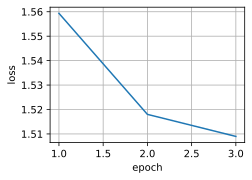

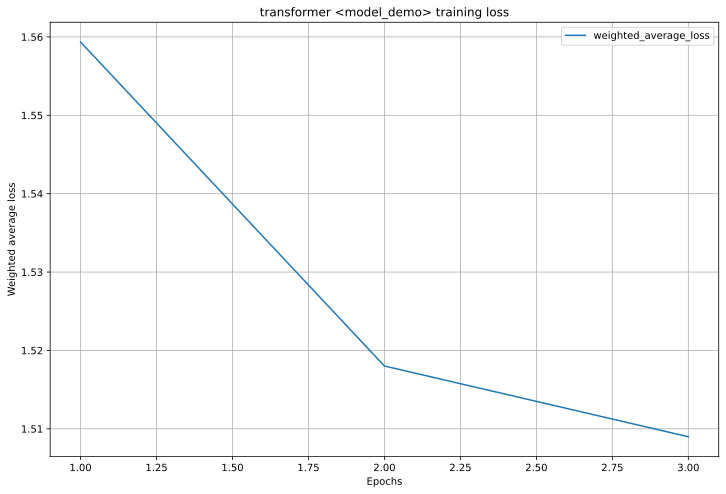

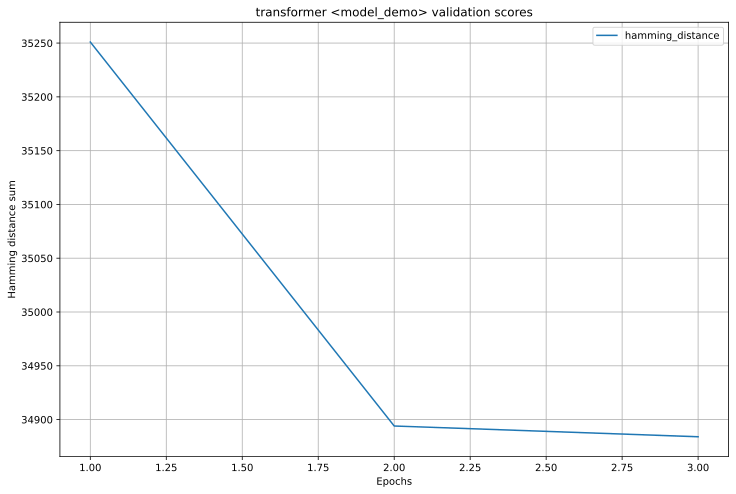

In [135]:
# train without validation
# train_seq2seq(model_demo, X_train, X_valid_len, Y_train, Y_valid_len, working_score_tensor, lr, num_epochs, batch_size, label_smoothing, amino_dict, device, model_name='model_demo')

# train with validation 
train_seq2seq(model_demo, X_train, X_valid_len, Y_train, Y_valid_len, working_score_tensor, lr, num_epochs, batch_size, label_smoothing, amino_dict, device, model_name='model_demo', X_validation=X_validation, Y_validation=Y_validation, X_validation_valid_len=X_validation_valid_len, Y_validation_valid_len=Y_validation_valid_len)

In [87]:
# save model 
# torch.save(net.state_dict(), file_name)
# pickle.dump(model_demo, open("model_demo.pkl", "wb"))

# load model
# model_demo = pickle.load(open("model_demo_22Jul12_0913AM", "rb"))
# model_demo = EncoderDecoder(encoder_demo, decoder_demo)
model_demo.load_state_dict(torch.load("model_demo_22Jul12_1024AM", map_location = ('cpu')))
# model.eval()


<All keys matched successfully>

#### Model predicting

In [88]:
target = ['SPT']
num_steps_prediction = 10 # max length of sequence to predict

dec_comple_peptide_pred, dec_prob, dec_attention_weight_seq = predict_greedy_single(model_demo, target[0], amino_dict, num_steps_prediction, device, save_attention_weights=True, print_info=True)

Conditional probability at position 1 is 0.08397284150123596
Conditional probability at position 2 is 0.13720513880252838
Conditional probability at position 3 is 0.16785955429077148
Conditional probability at position 4 is 0.9203442931175232
Input target sequence is SPT, predicted complementary peptide is TVT
Condition on input, predicted probability is 0.0017799410373475649


# Task 2: Train a base model 

#### Build base model

In [208]:
query_size, key_size, value_size, num_hiddens = 256, 256, 256, 256
num_layers, dropout = 4, 0.1
lr, num_epochs, batch_size, label_smoothing = 0.0004, 500, 6000, 0.1
ffn_num_input, ffn_num_hiddens, num_heads = 256, 1024, 8

norm_shape = [256] # 32 corresponds to the dim of such number to normalize
device = d2l.try_gpu()

In [209]:
encoder_base = TransformerEncoder(
	len(amino_dict), key_size, query_size, value_size, num_hiddens, 
	norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
	num_layers, dropout)
decoder_base = TransformerDecoder(
	len(amino_dict), key_size, query_size, value_size, num_hiddens, 
	norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
	num_layers, dropout)
model_base = EncoderDecoder(encoder_base, decoder_base)

In [210]:
model_base_total_params = sum(p.numel() for p in model_base.parameters())
model_base_total_trainable_params = sum(p.numel() for p in model_base.parameters() if p.requires_grad)

print('Base model: total number of parameters: {}'.format(model_base_total_params))
print('Base model: total number of trainable parameters: {}'.format(model_base_total_trainable_params))

Base model: total number of parameters: 7378968
Base model: total number of trainable parameters: 7378968


#### Model training

In [5]:
# To train a new model on GPU:
# 1. free GPU usage
# 2. restart kernel
# 3. reload all pretraining data

# check gpu_usage
#gpu_usage()

# free GPU usage
#free_gpu_cache()    

In [1]:
# train without validation
# train_seq2seq(model_base, X_train, X_valid_len, Y_train, Y_valid_len, working_score_tensor, lr, num_epochs, batch_size, label_smoothing, amino_dict, device, model_name='model_base', warmup=16000)

# train with validation
# train_seq2seq(model_base, X_train, X_valid_len, Y_train, Y_valid_len, working_score_tensor, lr, num_epochs, batch_size, label_smoothing, amino_dict, device, model_name='model_base_validation', warmup=16000, X_validation=X_validation, Y_validation=Y_validation, X_validation_valid_len=X_validation_valid_len, Y_validation_valid_len=Y_validation_valid_len)


In [211]:
# save model 
# torch.save(net.state_dict(), file_name)
# pickle.dump(model_base, open("model_base.pkl", "wb"))

# load model
# model_base = pickle.load(open("model_base.pkl", "rb"))
# model_demo = EncoderDecoder(encoder_demo, decoder_demo)
model_base.load_state_dict(torch.load("model_base_22Jul14_0326AM", map_location = ('cpu')))
# model.eval()

<All keys matched successfully>

#### Model prediction

In [156]:
num_steps_prediction = 10 # max length of target sequence to predict

print(X_validation_letter[0:10])
print(Y_validation_letter[0:10])

dec_comple_peptide_pred, dec_prob, dec_attention_weight_seq = predict_greedy_single(model_base, 'KSATTTVM', amino_dict, num_steps_prediction, device, save_attention_weights=True, print_info=True)

['ITLESGEF' 'TDAVIYIK' 'QDVLLVAQ' 'VVGFYDNE' 'ETVRIALV' 'GLYACVTS'
 'THVAMKIV' 'RRYEVNIV' 'KSATTTVM' 'GIEAGVEG']
['EIQRIFDF' 'DSMKVTLD' 'KSKTYAIS' 'ARVHAHIT' 'AKVEICWV' 'VSFYTTDS'
 'DKALWVTS' 'MEVQYWLF' 'EVAIALGG' 'GVMLNHTE']
Conditional probability at position 1 is 0.9551613330841064
Conditional probability at position 2 is 0.9726256132125854
Conditional probability at position 3 is 0.9443171620368958
Conditional probability at position 4 is 0.9340344071388245
Conditional probability at position 5 is 0.954649806022644
Conditional probability at position 6 is 0.9690737724304199
Conditional probability at position 7 is 0.9708462953567505
Conditional probability at position 8 is 0.9615174531936646
Conditional probability at position 9 is 0.9101817011833191
Input target sequence is KSATTTVM, predicted complementary peptide is EVAIALGG
Condition on input, predicted probability is 0.6440800841149936


# Task 3: Train a wide model 

#### Build wide model

In [220]:
query_size, key_size, value_size, num_hiddens = 512, 512, 512, 512
num_layers, dropout = 4, 0.1
lr, num_epochs, batch_size, label_smoothing = 0.0004, 500, 6000, 0.1
ffn_num_input, ffn_num_hiddens, num_heads = 512, 2048, 8

norm_shape = [512] # 32 corresponds to the dim of such number to normalize
device = d2l.try_gpu()

In [221]:
encoder_wide = TransformerEncoder(
	len(amino_dict), key_size, query_size, value_size, num_hiddens, 
	norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
	num_layers, dropout)
decoder_wide = TransformerDecoder(
	len(amino_dict), key_size, query_size, value_size, num_hiddens, 
	norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
	num_layers, dropout)
model_wide = EncoderDecoder(encoder_wide, decoder_wide)

In [222]:
model_wide_total_params = sum(p.numel() for p in model_wide.parameters())
model_wide_total_trainable_params = sum(p.numel() for p in model_wide.parameters() if p.requires_grad)

print('Base model: total number of parameters: {}'.format(model_wide_total_params))
print('Base model: total number of trainable parameters: {}'.format(model_wide_total_trainable_params))

Base model: total number of parameters: 29437976
Base model: total number of trainable parameters: 29437976


#### Model training

In [114]:
# train without validation
# train_seq2seq(model_wide, X_train, X_valid_len, Y_train, Y_valid_len, working_score_tensor, lr, num_epochs, batch_size, label_smoothing, amino_dict, device, model_name='model_wide', warmup=35000)

# train with validation 
# train_seq2seq(model_wide, X_train, X_valid_len, Y_train, Y_valid_len, working_score_tensor, lr, num_epochs, batch_size, label_smoothing, amino_dict, device, model_name='model_wide_validation', warmup=35000, X_validation=X_validation, Y_validation=Y_validation, X_validation_valid_len=X_validation_valid_len, Y_validation_valid_len=Y_validation_valid_len)


In [223]:
model_wide.load_state_dict(torch.load("model_wide_22Jul16_1011AM", map_location = ('cpu')))

<All keys matched successfully>

#### Model prediction

In [181]:
# interesting examples to demonstrate the power of the model

PDB_beta_strand_1 = 'NRIELKGT' # PDB labels = 'VVARTKYK' (training sample that generate different labels)
Biochem_target_1 = 'EQVTNVG' # paper chosen peptide = 'EILVSYQ' (alpha-synuclein residues 61-67)
Biochem_target_2 = 'QKLVFFA' # paper chosen peptide = 'FKLSVIT' (Abeta42 residues 15-22)

task_target_1 = None

prediction_length = 8

In [224]:
# search whether the target exists in PDB

# target, complementary_seq, counts, promiscuity, length, working_score, hb_pattern, para/anti, freq

# BSn_data_dataset_sequence -- dataset contains all samples
# BSn_data_dataset2 -- dataset with negative working scores removed

print("Dataset search result: \n", search_target(BSn_data_dataset_sequence[:, :6], 'NRIELKGT'))

Dataset search result: 
 [['NRIELKGT' 'VVARTKYK' 2 0 8 128.0]]


In [225]:
# greedy single prediction

dec_comple_peptide_pred, dec_prob, dec_attention_weight_seq = predict_greedy_single(model_wide, 'NRIELKGT', amino_dict, prediction_length + 2, device, save_attention_weights=True, print_info=True)

Conditional probability at position 1 is 0.9358905553817749
Conditional probability at position 2 is 0.8671083450317383
Conditional probability at position 3 is 0.7962782979011536
Conditional probability at position 4 is 0.922514021396637
Conditional probability at position 5 is 0.9255252480506897
Conditional probability at position 6 is 0.9258487224578857
Conditional probability at position 7 is 0.9241359233856201
Conditional probability at position 8 is 0.9532920718193054
Conditional probability at position 9 is 0.9239785075187683
Input target sequence is NRIELKGT, predicted complementary peptide is VEARTKYK
Condition on input, predicted probability is 0.415803644044098


In [226]:
# unique top candidates sampling

# large num_candidates is recommended if we have enough memory

num_candidates = 200
max_iter = 20

peptide_candidates = sample_candidates(model_wide, 'NRIELKGT', num_candidates, amino_dict, prediction_length + 2, device, max_iter=max_iter)
peptide_candidates

number of total candidates sampled: 520
number of unique top candidates successfully sampled: 200


[('VEARTKYK', 0.41580343),
 ('VELDGDVK', 0.06144125),
 ('VVARTKYK', 0.02386108),
 ('VIARTKYK', 0.00272741),
 ('VHARTKYK', 0.0027173),
 ('VDARTKYK', 0.00264283),
 ('VNARTKYK', 0.00247033),
 ('VEIDGDVK', 0.00234948),
 ('VELDGDVT', 0.00225941),
 ('VEFDGDVK', 0.00188375),
 ('VFARTKYK', 0.00187691),
 ('VQARTKYK', 0.00175555),
 ('VEARTKCK', 0.00161625),
 ('VEARTKNK', 0.00161595),
 ('VKARTKYK', 0.00158806),
 ('VEARTK<bos>V', 0.00157333),
 ('IEARTKYK', 0.00154358),
 ('VTARTKYK', 0.00153716),
 ('VLARTKYK', 0.00153294),
 ('VEMDGDVK', 0.00146858),
 ('VEAR<eos>KYK', 0.00137223),
 ('VEPDGDVK', 0.00134372),
 ('VEAR<pad>KYK', 0.00130872),
 ('VEARTKVK', 0.00122431),
 ('DVARTKYK', 0.00120705),
 ('VEARTKIK', 0.0012029),
 ('CVARTKYK', 0.00120138),
 ('VEAR<bos>VIL', 0.00104041),
 ('VEART<eos>KY', 0.00101647),
 ('VEART<pad>KY', 0.00100345),
 ('VEARTKPV', 0.00100079),
 ('NVARTKYK', 0.00099551),
 ('VEATTKYK', 0.00099029),
 ('VEARTEYP', 0.00098051),
 ('RVARTKYK', 0.00098022),
 ('VEARTKY<pad>', 0.0009635),
 ('

In [227]:
# target and complementary peptide evaluation

evaluate_single(model_wide, 'NRIELKGT', 'VVARTKYK',amino_dict, prediction_length + 2, device, print_info=True)

Conditional probability at position 1 is 0.9358905553817749
Conditional probability at position 2 is 0.043088313192129135
Conditional probability at position 3 is 0.921801745891571
Conditional probability at position 4 is 0.9240824580192566
Conditional probability at position 5 is 0.9230687618255615
Conditional probability at position 6 is 0.9244361519813538
Conditional probability at position 7 is 0.9250525832176208
Conditional probability at position 8 is 0.9524264931678772
Conditional probability at position 9 is 0.9239492416381836
Input target sequence is NRIELKGT, complementary peptide is VVARTKYK, evaluated probability is 0.023861062918231507


In [228]:
# greedy batch prediction -- can be used to scan possible targets

print(X_validation_letter[:10])
print(Y_validation_letter[:10])

peptide_pred = predict_greedy_batch(model_wide, X_validation_letter[:10], amino_dict, prediction_length + 2, device)
print("Greedy batch prediction: \n", peptide_pred)

['KEMIQEVI' 'FTMLELYE' 'KQVFTVPY' 'DYEVTLTR' 'FHLDVDIS' 'DLRAMPAH'
 'KTIYIYNV' 'SREYHICV' 'VYSILTSS' 'KVRVKMET']
['LAKPIYLT' 'VRGIEYVK' 'HIIVKLEG' 'RVTLTALY' 'LHFTVKGI' 'SNVWKLGA'
 'GTFICGIN' 'TLTVVAHV' 'FYLTAETI' 'TVEVEFSN']
Greedy batch prediction: 
 [['KEMIQEVI' 'LAKPIYLT' '0.601555347442627']
 ['FTMLELYE' 'VRGIEYVK' '0.44587305188179016']
 ['KQVFTVPY' 'HIIVKLEG' '0.6263747215270996']
 ['DYEVTLTR' 'RVTLTALY' '0.6022646427154541']
 ['FHLDVDIS' 'LHFTVKGI' '0.6096101403236389']
 ['DLRAMPAH' 'SNVWKLGA' '0.5396904945373535']
 ['KTIYIYNV' 'GTFICGIN' '0.5399317145347595']
 ['SREYHICV' 'TLTVVAHV' '0.5907752513885498']
 ['VYSILTSS' 'FYLTAETI' '0.5898668169975281']
 ['KVRVKMET' 'TVEVEFSN' '0.5440295338630676']]


# Task 4: Model Base Validation analysis

#### Build model base validation

In [190]:
query_size, key_size, value_size, num_hiddens = 256, 256, 256, 256
num_layers, dropout = 4, 0.1
lr, num_epochs, batch_size, label_smoothing = 0.0004, 500, 6000, 0.1
ffn_num_input, ffn_num_hiddens, num_heads = 256, 1024, 8

norm_shape = [256] # 32 corresponds to the dim of such number to normalize
device = d2l.try_gpu()

In [191]:
encoder_base = TransformerEncoder(
	len(amino_dict), key_size, query_size, value_size, num_hiddens, 
	norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
	num_layers, dropout)
decoder_base = TransformerDecoder(
	len(amino_dict), key_size, query_size, value_size, num_hiddens, 
	norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
	num_layers, dropout)
model_base_validation = EncoderDecoder(encoder_base, decoder_base)

In [192]:
model_base_validation_total_params = sum(p.numel() for p in model_base_validation.parameters())
model_base_validation_total_trainable_params = sum(p.numel() for p in model_base_validation.parameters() if p.requires_grad)

print('Base model: total number of parameters: {}'.format(model_base_validation_total_params))
print('Base model: total number of trainable parameters: {}'.format(model_base_validation_total_trainable_params))

Base model: total number of parameters: 7378968
Base model: total number of trainable parameters: 7378968


In [193]:
# load the model
model_base_validation.load_state_dict(torch.load("model_base_validation_22Jul18_0536AM", map_location = ('cpu')))


<All keys matched successfully>

#### Hamming distance analysis on validation set

In [213]:
prediction_length = 8

num_minibatch = 50

print(X_validation_letter[:10])
print(Y_validation_letter[:10])

peptide_pred_list = []
num_iter = int(len(X_validation_letter)/num_minibatch)

for i in range(num_iter):
	peptide_pred = predict_greedy_batch(model_base_validation, X_validation_letter[num_minibatch*i:num_minibatch*i+num_minibatch], amino_dict, prediction_length + 2, device)
	peptide_pred_list.append(peptide_pred)
peptide_pred_array = np.vstack(peptide_pred_list)
peptide_pred_array_new = np.hstack([peptide_pred_array, np.array(Y_validation_letter).reshape(-1, 1)])
# target, prediction, greedy_prob, label

print(peptide_pred_array_new.shape)

['KEMIQEVI' 'FTMLELYE' 'KQVFTVPY' 'DYEVTLTR' 'FHLDVDIS' 'DLRAMPAH'
 'KTIYIYNV' 'SREYHICV' 'VYSILTSS' 'KVRVKMET' 'LEGVFSFS' 'GTNSIKLV'
 'TEGIWRGV' 'KRTEDKTS' 'FVEEVFEN' 'EFFIIAYE' 'TNASLVIK' 'AIFDGTVT'
 'CFEVASIP' 'KCNYRIWT' 'LVYETVRV' 'SVYLFYKK' 'YHLKFSVE' 'TMQMMFGC'
 'VAGQYEAA' 'FFQLFYTL' 'SRSRVLFT' 'ACVCVITK' 'GVKLRLTV' 'KLVHYDVL'
 'LLETNQTL' 'CGEGILIK' 'IHITFQTR' 'IAIEYTSI' 'TASYTWDR' 'RLWMAGPM'
 'HLSVQGPY' 'ATAEAFVE' 'AIPANIRI' 'YRLRIDLT' 'GEGEIQAT' 'LCQVSGLL'
 'MLAFGQVG' 'HTGCVAFG' 'EIRLTRIL' 'NRIELKGT' 'VKGQWKSV' 'TGWTGYFD'
 'IIEASATF' 'RLFESGLR']
['LAKPIYLT' 'VRGIEYVK' 'HIIVKLEG' 'RVTLTALY' 'LHFTVKGI' 'SNVWKLGA'
 'GTFICGIN' 'TLTVVAHV' 'FYLTAETI' 'TVEVEFSN' 'VRITQSDR' 'ASLSWVIS'
 'ATFPVNII' 'DFQINQTV' 'RLRVWRRR' 'RIFEFKVV' 'GFSNSLVY' 'IYESFKYS'
 'RIREMRLI' 'VFRVNTVN' 'AVPYTYLS' 'ALAFVIQY' 'VEATCNVT' 'MGTLFYRL'
 'AAVQTQEH' 'KCGTHIQF' 'MRADGSLK' 'TETCYSNW' 'EVTSAEIQ' 'VVNYIRTI'
 'PQKLTFTF' 'IFIISYIG' 'VELHLFFD' 'REIVTDER' 'PVEVTTEE' 'AEYNVQHF'
 'YFSYTAEF' 'VTAEIRVR' 'IEVMKKVS' 'PLL

In [215]:
# process the results to study mismatched sequences
# target, prediction, prob, label

num_validation = len(X_validation_letter)
total_residue = num_validation * prediction_length
print("Sequence length:", prediction_length)

peptide_validation_mismatchs = peptide_pred_array_new[peptide_pred_array_new[:, 1] != np.array(Y_validation_letter)]
print("mismatched sequences: {}, total sequences: {}".format(peptide_validation_mismatchs.shape[0], num_validation))

peptide_validation_hamming = hamming_distance_str(peptide_pred_array_new[:, 1], np.array(Y_validation_letter))
print("mismatched residues: {}, total residues: {}".format(peptide_validation_hamming, total_residue))

print("----------------------------------------------------------")
print("Sequences prediction accuracy: ", (num_validation-peptide_validation_mismatchs.shape[0])/num_validation)
print("Residue prediction accuracy: ", (total_residue-peptide_validation_hamming)/total_residue) 

Sequence length: 8
mismatched sequences: 1428, total sequences: 5000
mismatched residues: 6164, total residues: 40000
----------------------------------------------------------
Sequences prediction accuracy:  0.7144
Residue prediction accuracy:  0.8459


In [216]:
print("target      prediction      probability       PDB_label")
print(peptide_validation_mismatchs[0:20, :])

target      prediction      probability       PDB_label
[['KVRVKMET' 'SILVDFAT' '0.008602997288107872' 'TVEVEFSN']
 ['TEGIWRGV' 'WTFPVNII' '0.11936737596988678' 'ATFPVNII']
 ['LVYETVRV' 'LTYVKVEL' '0.01129102148115635' 'AVPYTYLS']
 ['TMQMMFGC' 'VSTSFYRM' '0.13841383159160614' 'MGTLFYRL']
 ['VAGQYEAA' 'AVVRHVQH' '0.3287472426891327' 'AAVQTQEH']
 ['FFQLFYTL' 'CLSLVIIF' '0.002241917420178652' 'KCGTHIQF']
 ['KLVHYDVL' 'VVNYIRTV' '0.49400004744529724' 'VVNYIRTI']
 ['IAIEYTSI' 'LNIRYADY' '0.0031037142034620047' 'REIVTDER']
 ['HLSVQGPY' 'YFSYTAEY' '0.1979689598083496' 'YFSYTAEF']
 ['YRLRIDLT' 'PLLKMTTH' '0.26479727029800415' 'PLLKMTTM']
 ['EIRLTRIL' 'EVRYVLEF' '0.10515044629573822' 'AVRYVLEF']
 ['NRIELKGT' 'VEARTKYK' '0.2505059540271759' 'VVARTKYK']
 ['TGWTGYFD' 'LNWDTKLS' '0.2468978762626648' 'LNWDTKLV']
 ['QFEISITS' 'QFVFMYLH' '0.00542890839278698' 'YSKYSITV']
 ['PQFKVDGK' 'YEWRSGIW' '0.021402446553111076' 'FKAETNIS']
 ['LHKTFISV' 'KITYEYKE' '0.167838454246521' 'KITYEYKF']
 ['RVLVVCAE' 'GVI

In [218]:
dec_comple_peptide_pred, dec_prob, dec_attention_weight_seq = predict_greedy_single(model_base_validation, 'KVRVKMET', amino_dict, prediction_length + 2, device, save_attention_weights=True, print_info=True)

Conditional probability at position 1 is 0.5547669529914856
Conditional probability at position 2 is 0.5106884837150574
Conditional probability at position 3 is 0.35666120052337646
Conditional probability at position 4 is 0.928555428981781
Conditional probability at position 5 is 0.8865200281143188
Conditional probability at position 6 is 0.35324156284332275
Conditional probability at position 7 is 0.3998695909976959
Conditional probability at position 8 is 0.8044186234474182
Conditional probability at position 9 is 0.9102398753166199
Input target sequence is KVRVKMET, predicted complementary peptide is SILVDFAT
Condition on input, predicted probability is 0.00860294306477206


In [219]:
num_candidates = 200
max_iter = 20

peptide_candidates = sample_candidates(model_base_validation, 'KVRVKMET', num_candidates, amino_dict, prediction_length + 2, device, max_iter=max_iter)
peptide_candidates

number of total candidates sampled: 400
number of unique top candidates successfully sampled: 200


[('TVEVEFSN', 0.03208165),
 ('TVEVEFSA', 0.03043992),
 ('SVEVEFSN', 0.02112612),
 ('SIVVEFSN', 0.01900584),
 ('SIEVEFSA', 0.01688151),
 ('SIEVEFSN', 0.01668579),
 ('SVEVEFSA', 0.01624979),
 ('EVEVEFSN', 0.01564283),
 ('SILVDFAT', 0.00860299),
 ('EVEVEFSA', 0.00834312),
 ('SIVVEFSA', 0.00530461),
 ('EIEVEFSN', 0.00451858),
 ('VVEVEFSN', 0.00445714),
 ('NVEVEFSN', 0.00444524),
 ('NVEVEFSA', 0.00428088),
 ('SILVDFRV', 0.00355952),
 ('STLILVHG', 0.00337687),
 ('SVEVEFAK', 0.00321075),
 ('VVEVEFSA', 0.00316605),
 ('SYLVEFSN', 0.00303602),
 ('TIEVEFSA', 0.00291795),
 ('IVEVEFSN', 0.00265904),
 ('SILVDFSI', 0.00222193),
 ('SLEVEFSA', 0.00216843),
 ('DVEVEFSN', 0.00215328),
 ('DVEVEFSA', 0.00213032),
 ('SILVDLTI', 0.0020582),
 ('SLEVEFSN', 0.00198717),
 ('SYTVEFSA', 0.00193645),
 ('SYLVEFSA', 0.00187258),
 ('IVEVEFSA', 0.00187005),
 ('TIEVEFSN', 0.001834),
 ('SVVVEFSN', 0.0016094),
 ('SILVEFSN', 0.00149907),
 ('SILVDCGY', 0.00143761),
 ('SVTVEFSN', 0.00142241),
 ('EVEVTFSN', 0.00140909),
 ('WV

#### Model attention analysis

#### Number of parameters calculation 

N: number of layers <br>
H: hidden dimensions

Encoder embedding: $24 \times H$ <br>

Encoder self attention -- key projection, value projection, query projection, final projection: $H^{2} \times 4$ <br>
Encoder pointwise MLP: $H \times 4H \times 2 = H^{2} \times 8$

Decoder embedding: $24 \times H$ <br>

Decoder self attention -- key projection, value projection, query projection, final projection: $H^{2} \times 4$ <br>
Decoder-encoder attention -- key projection, value projection, query projection, final projection: $H^{2} \times 4$ <br>
Decoder pointwise MLP: $H \times 4H \times 2 = H^{2} \times 8$

Ouput Projection: $H \times 24$ 

Total parameters: $24 \times H + (H^{2} \times 4 + H^{2} \times 8) \times N + 24 \times H + (H^{2} \times 4 + H^{2} \times 4 + H^{2} \times 8) \times N + H \times 24  $ <br> 
$ = 28 \times H^{2} \times N + 72 \times H$

#### Potential problems

1. Positional encoding failed to work in predict sequences------------- fixed 
2. 'bos', 'eos' not trained? ------------------------------------------ fixed 
3. Ramdomize each batch ----------------------------------------------- fixed 
4. Softmax in prediction ---------------------------------------------- fixed 
5. write functions for training-preposessing -------------------------- fixed
6. write functions for prediction ------------------------------------- fixed
7. label smoothing: alter learning truth distribution ----------------- fixed 
8. weighting of each sample: sample weights in loss ------------------- fixed
9. adjust learning rate ----------------------------------------------- not changed since adam is insensitive to learning rate
10. loss shown too small ---------------------------------------------- fixed 
11. batch size and training steps and all other hyperparameter--------- set

#### Things to do

1. Assigne weights to each sample ------------------------------- done 
2. hyperparameter for base model training ----------------------- done 
3. train on imperial GPU ---------------------------------------- done 
4. Write sampling sequence + prob function ---------------------- moved 
5. Write functions for prob of pair sequences ------------------- moved
6. Consider anti para / para condition -------------------------- ignore this condition + ignore hb_pattern for now
7. save model parameters with current time ---------------------- done 
8. check GPU availablity ---------------------------------------- done
9. Request a notebook for longer or more GPU on jupyter? 100epochs==50hours for 1 GPU  ---- done 
10. Save loss plots --------------------------------------------- done 
11. Convert jupyter notebook to scriptfor trainning ------------- done 
12. Lean how to train on one GPU on imperial cluster ------------ done
13. Embedding and linear initialization adjust ------------------ done 
14. Examine on both training and validation --------------------- done 
15. Hamming distance systematically lower (valida) -------------- done 
16. Prob of training model comple peptides by model systemtically higher than random comple peptides (train)
17. Write sampling sequence + prob function --------------------- done 
18. Write functions for prob of pair sequences
19. Extract attention weights to view correlation
20. Maybe train a base line version with only equal weights length 7 and 8 ---- not now
21. try to predict binding energy 
22. Track validation loss or find another good metric ----------- done
23. clean notebook ---------------------------------------------- done 
24. maybe data augmentation or alphafold to add high quality model
25. batch sampling procedure and batch prediction---------------- done 
26. try gated attention from alphafold2
27. try data augmentation and expand dataset from alphafold2
28. try bidirectional mask from BERT alphafold2


#### HPC version tracker

1. model_base: 13072022_UROP_model_base_modified
2. model_wide: 14072022_UROP_model_wide
3. model_base_validation: 17072022_UROP_model_base_validation
4. model_wide_validation: 17072022_UROP_model_wide_validation